# Ligand

In [303]:
from IPython.display import Markdown, display
from rdkit import Chem
import rdkit
from rdkit.Chem import AllChem, Draw
from pymol import cmd
from Bio.PDB.PDBParser import PDBParser
import pubchempy 
import pandas as pd
from biopandas.pdb import PandasPdb
from io import StringIO

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
def printmd(string):
    display(Markdown(string))

## Search on PubChem

In [304]:
keyword = 'kynurenine'
lig_res = 'LIG'
lig_name = f'{lig_res}_PLP'
file = f'{lig_name}.pdb'
adfr_path = "/home/marco/ADFRsuite-1.0/bin"

SearchResults = pubchempy.get_compounds(keyword, namespace='name', searchtype=None, as_dataframe=False)
for n, i in enumerate([x.synonyms[0] for x in SearchResults]):
    printmd(f'Select **{n}** for `{i}`')
aa = SearchResults[int(input())].isomeric_smiles


/home/marco/anaconda3/envs/revdock/lib/python3.8/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0:
/home/marco/anaconda3/envs/revdock/lib/python3.8/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0:
/home/marco/anaconda3/envs/revdock/lib/python3.8/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0:
/home/marco/anaconda3/envs/revdock/lib/python3.8/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0:
/home/marco/anaconda3/envs/revdock/lib/python3.8/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0:
/home/marco/anaconda3/envs/revdock/lib/python3.8/site-packages/pubchempy.py:563: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.charge is not 0

KeyboardInterrupt: 

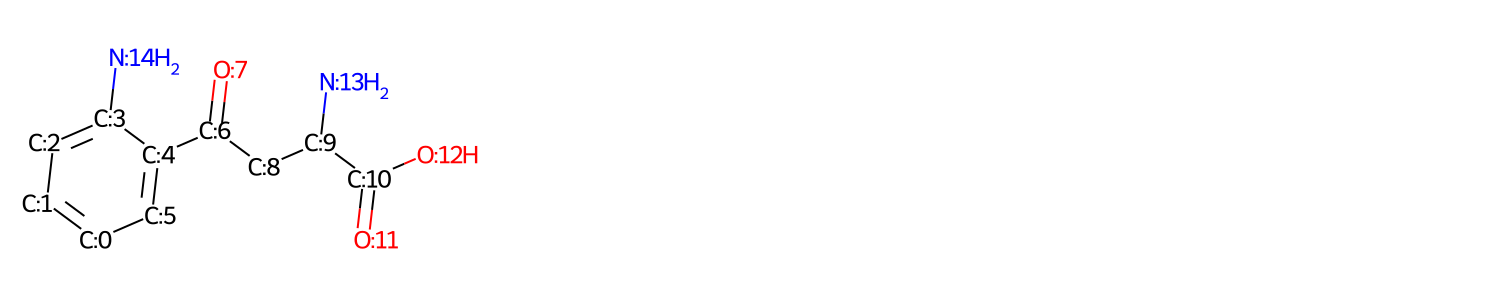

In [227]:
# pubchempy.Compound
plp = 'CC1=NC=C(C(=C1O)C)COP(=O)([O-])[O-]'
m = Chem.MolFromSmiles(aa)
m2 = Chem.MolFromSmiles(plp)
Draw.MolsToGridImage([mol_with_atom_index(m)], subImgSize=(500,300))

## Choose the nuber of the Nitrogen to bond on PLP

 13


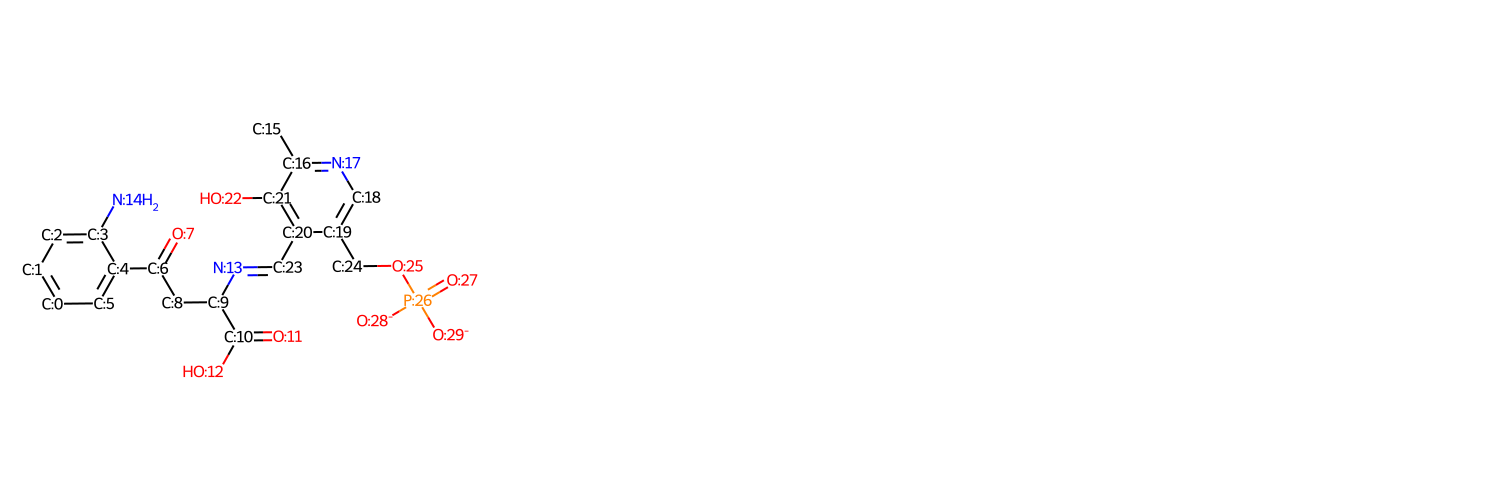

In [228]:
N = int(input())
cm = Chem.CombineMols(m,m2)
em = Chem.EditableMol(cm)
em.AddBond(N,len(list(m.GetAtoms()))+8,Chem.BondType.DOUBLE)
nm = em.GetMol()
Chem.SanitizeMol(nm)
rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE
Draw.MolsToGridImage([mol_with_atom_index(nm)], subImgSize=(500,500))

In [229]:
# nm = Chem.MolFromSmiles(aa+plp)
nm=Chem.AddHs(nm)
# run ETKDG 10 times
cids = AllChem.EmbedMultipleConfs(nm, numConfs=1)
# print(len(cids))
rmslist = []
AllChem.AlignMolConformers(nm, RMSlist=rmslist)
AllChem.ComputeGasteigerCharges(nm)
pdb = Chem.MolToPDBBlock(nm)
print(pdb, 
      file =open(file, 'w')
     )  


parser = PDBParser(PERMISSIVE=1)
H, A =[], []
structure = parser.get_structure('f', file)

for model in structure:
    for chain in model:
        for res in chain:
            for atom in res:
                if 'H' in atom.id:
                    H.append(atom.id)
                else:
                    A.append(atom.id)
cmd.reinitialize()
cmd.load(file)
cmd.select('PLP', f"name {'+'.join(A[-15:] + H[-8:])}")
cmd.select("LIG", 'not PLP')
cmd.alter("PLP", "resn='PLP'")
cmd.alter("LIG", f"resn='{lig_res}'")
cmd.save(file)

## Get atom numbers for reactionsNeighCAlpha

In [268]:
conect.loc[CAlpha].iloc[0].dropna().astype(int).values.tolist()

[19, 3, 22, 37]

In [291]:
ppdb = PandasPdb().read_pdb(file)
df = ppdb.df['HETATM']
NAlpha = df[df['atom_name']=='N1']['atom_number'].iloc[0]
conect = pd.read_table(StringIO(''.join([x for x in open(file).readlines() if x.startswith('CONECT')])), delim_whitespace=True, header=None).drop(0, axis=1).set_index(1)
Neigh = conect.loc[NAlpha].dropna().astype(int).tolist()
CAlpha = df[(df['atom_number'].isin(Neigh))&(df['residue_name']!='PLP')]['atom_number'].tolist()
NeighCAlpha = conect.loc[CAlpha].iloc[0].dropna().astype(int).values.tolist()
CBeta = df[(df['atom_number'].isin(NeighCAlpha))&(df['element_symbol']=='C')]['atom_number'].tolist()
NeighCBeta = conect.loc[CBeta].iloc[0].dropna().astype(int).values.tolist()
CBetaBonds = [k for k,v in conect.loc[CBeta].fillna('NO').to_dict('index').items() for x in v.items() if x[1]!='NO']
CBetaAtoms = pd.DataFrame([[x, CBetaBonds.count(x)] for x in set(CBetaBonds)], columns=['atom','bonds'])
CBetaAtoms['type'] = CBetaAtoms['bonds'].apply(lambda x: 'decarboxylase' if x==3 else 'betalyase')
CBetaAtoms['atom'] = CBetaAtoms['atom'].apply(lambda x: df[df['atom_number']==x]['atom_name'].iloc[0])
CBetaAtoms = dict(CBetaAtoms[['type', 'atom']].values.tolist())

## PLP PLane atoms
CPLP = df[(df['atom_number'].isin(Neigh))&(df['residue_name']=='PLP')]['atom_number'].tolist()
NeighCPLP = conect.loc[CPLP].iloc[0].dropna().astype(int).values.tolist()
CFulcrum = df[(df['atom_number'].isin(NeighCPLP))&(df['element_symbol']=='C')]['atom_number'].tolist()
Plane = conect.loc[CFulcrum].iloc[0].dropna().astype(int).values.tolist()
PlaneAtoms = df[df['atom_number'].isin(Plane)]['atom_name'].tolist()
CAlpha = df[df['atom_number'].isin(CAlpha)]['atom_name'].tolist()[0]
CPLP = df[df['atom_number'].isin(CPLP)]['atom_name'].tolist()[0]
CBetaAtoms, PlaneAtoms, CAlpha
PlaneAtoms

['C14', 'C16', 'C17']

## `prepare_ligand` by ADFRsuite-1.0 

In [234]:
! {adfr_path}/prepare_ligand -l {file}

# Receptors

In [8]:
import pandas as pd, gzip, tarfile, urllib, os, sys, glob, requests, json, random, numpy as np, re, time
from Bio.Blast.Applications import NcbiblastpCommandline as blastp
from Bio.Blast import NCBIXML
from Bio import SeqIO, SearchIO
from Bio.PDB import PDBParser as PDB, PDBIO
# from sklearn.cluster import DBSCAN
from multiprocessing import Pool
# from biopandas.pdb import PandasPdb
import tempfile as tfile
from subprocess import Popen, PIPE
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import math
from pymol import cmd
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

In [9]:
def convert_ac(list, From, To, taxon='*'):
    '''
    IN: list of accession number (NCBI,UniProt; ENSEMBL, orthodb, ecc)
    original DB (see: https://www.uniprot.org/help/api_idmapping)
    new DB (see: https://www.uniprot.org/help/api_idmapping)
    taxid (eg. 9606), DEFAULT=all
    OUT: dataframe with ID mapping of the 2 database selected
    '''
    url = 'https://www.uniprot.org/uploadlists/'
    
    params = {
        'from': From,
        'to': To,
        'format': 'tab',
        'query': ' '.join(list),
        'taxon': str(taxon),
        'columns': 'id,reviewed',
        }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    df = pd.read_csv(urllib.request.urlopen(req), sep='\t').drop('Status', axis=1, errors='ignore')
    df = df[df.columns[:2]]
    if 'Entry' in df.columns:
        df.columns = ['To', 'From']
    return df

def pdb2fasta(pdb):
    """convert pdb file to fasta format for each chain"""
    fasta = []
    
    if pdb.startswith('http'):
        if pdb.endswith('.gz'):
            seq = list(SeqIO.parse(gzip.open(urllib.request.urlopen(pdb),'rt'), 'pdb-atom'))
        else:
            seq = list(SeqIO.parse(StringIO(urllib.request.urlopen(pdb).read().decode('UTF-8')), 'pdb-atom'))

    elif pdb.endswith('.gz'):
        seq = list(SeqIO.parse(gzip.open(pdb,'rt'), 'pdb-atom'))
        
    else:
        seq = list(SeqIO.parse(open(pdb,'r'), 'pdb-atom'))
        
    for record in seq:
        
        if record.annotations['start'] < 1:
            fasta.append(SeqRecord((record.seq[abs(record.annotations['start'])+1:]), 
                             description = pdb.strip('.pdb'), 
                             id = record.annotations['chain']))
        else:
            fasta.append(SeqRecord(('X'*int(record.annotations['start']-1)+record.seq[0:]),
                             description = pdb.strip('.pdb'),
                             id = record.annotations['chain']))
    return fasta


def match_fasta_position(query,subject_list,num=None):
    """return dataframe of position matching in subject and query fasta, or a dictionary given a list of number"""
    
    subject = '\n'.join([f'>{x.id}\n{str(x.seq)}' for x in subject_list])
    child = Popen(' '.join(['blastp', 
                         '-query',fr'<(echo -e ">{query.id}\n{query.seq}")',
                         '-subject', fr'<(echo -e "{subject}")',
                         '-evalue', '10e-5',
                         '-outfmt', '5',
                         '-max_hsps', '1']),
                        stdout=PIPE, stderr=PIPE, shell=True, executable='/bin/bash'
           ) 
    
    df = []
    xml = list(SearchIO.parse(child.stdout, "blast-xml"))
    for q in xml:
        for s in q:
            x=s[0]
            hit_gap = np.array([index for index, value in enumerate(x.hit) if value == '-'])
            q_gap = np.array([index for index, value in enumerate(x.query) if value == '-'])
            hit_num=list(np.arange(x.hit_start+1,x.hit_end+1))
            q_num=list(np.arange(x.query_start+1,x.query_end+1))
            for i in hit_gap:
                hit_num.insert(i,np.nan)
            for i in q_gap:
                q_num.insert(i,np.nan)
            df.append(list(zip(len(x.query)*[query.id],len(x.query)*[s.description],x.query,q_num,x.hit,hit_num)))
    df = pd.DataFrame([j for i in df for j in i],columns=['query','sequence','query_res','query_num','hit_res','hit_num'])
    df.set_index(['query'],inplace=True)
    if num==None:
        return df
    else:
        return df[df.query_num.isin(list(map(int,num)))].to_dict('records')
    

def build_homoligo(subject, template, ac='structure'):
    cmd.reinitialize()
    try:
        cmd.load(template, 'template')
    except:
        cmd.read_pdbstr(urllib.request.urlopen(template).read().decode('UTF-8'), 'template')
    cmd.split_states('template')
    cmd.delete('template')
    cmd.split_chains(f'template_0001 and polymer.protein')
    cmd.delete(f'template_0001')    
    df = match_fasta_position(pdb2fasta(subject)[0], pdb2fasta(template))
    objs = list(cmd.get_object_list('all'))
    cmd.load(subject, 'subject')
    
    n=65  ##letter A
    for mol in objs:
        chain = cmd.get_chains(mol)[0]
        if chain in set(df['sequence'].tolist()):
            cmd.create(f'sub_{mol}', f"resi {int(df[df['sequence']==chain]['query_num'].min())}-{int(df[df['sequence']==chain]['query_num'].max())} and subject")
            cmd.alter(f'(sub_{mol})', f"chain='{chr(n)}'")
            cmd.align(f'sub_{mol}', mol)
            n+=1
    cmd.save(f'{ac}.pdb', 'sub_*')

def build_homoligo_manual(subjects, template, ac='structure'):
    cmd.reinitialize()
    try:
        cmd.load(template, 'template')
    except:
        cmd.read_pdbstr(urllib.request.urlopen(template).read().decode('UTF-8'), 'template')
    cmd.split_states('template')
    cmd.delete('template')
    cmd.split_chains(f'template_0001 and polymer.protein')
    cmd.delete(f'template_0001')    
    objs = list(cmd.get_object_list('all'))
    
    n=65  ##letter A
    for chain, sub in subjects.items():
        df = match_fasta_position(pdb2fasta(sub)[0], [s for s in pdb2fasta('https://files.rcsb.org/view/7CQK.pdb') if s.id==chain])
        try:
            cmd.load(sub, 'subject')
        except:
            cmd.read_pdbstr(urllib.request.urlopen(sub).read().decode('UTF-8'), 'subject')
        mainChain = cmd.get_chains('subject')[0]
        cmd.create(f'sub_{chain}', f"resi {int(df[df['sequence']==chain]['query_num'].min())}-{int(df[df['sequence']==chain]['query_num'].max())} and subject and chain {mainChain}")
        cmd.alter(f'(sub_{chain})', f"chain='{chr(n)}'")
        cmd.align(f'sub_{chain}', f'template_0001_{chain}')
        n+=1
        cmd.delete(f'subject')
    cmd.save(f'{ac}.pdb', 'sub_*')
    
def best_structure(ac):
    try:
        df = getfeatures(ac)
        leng = df['sequence.length'].iloc[0]*0.7
        pdb = pd.json_normalize([x  for x in df.dbReferences[0] if x['type']=='PDB'])
        pdb = pdb[pdb['properties.chains'].apply(lambda x: abs(eval(x.split('=')[-1]))) > leng]
        multi = pdb[pdb['properties.chains'].str.contains('/')]
        pdb = multi if not multi.empty else pdb
        pdb['properties.resolution'] = pdb['properties.resolution'].apply(lambda x: x.split(' ')[0]).astype(float)
        return pdb.loc[pdb['properties.resolution']==pdb['properties.resolution'].min()]['id'].iloc[0]
    except:
        return None
    
def getfeatures(uniprot_id):
    """return the Uniprot complete dataset for a given Uniprot ID"""
    try:
        r = requests.get("https://www.ebi.ac.uk/proteins/api/proteins?size=-1&accession=" + uniprot_id, 
                         headers={ "Accept" : "application/json"})
        data = pd.json_normalize(r.json())
        return data
    except:
        return str(uniprot_id) + ' not_found'

In [10]:
cwd = os.getcwd()

In [11]:
os.chdir(cwd)
specie = 'Mus_musculus'
taxid = 10090
try: # existing folder
    os.mkdir(specie)
except:
    pass
os.chdir(specie)
ncbi_acc = pd.read_table(f'http://bioinformatics.unipr.it/B6db/tmp/{specie}.tab',header=None)
acc = convert_ac(ncbi_acc[2],'P_REFSEQ_AC','ACC', taxid)
gene_id = convert_ac(acc['To'],'ACC', 'P_ENTREZGENEID', taxid)
accession = convert_ac(gene_id['To'].drop_duplicates().astype(str),'P_ENTREZGENEID', 'ACC', taxid).drop_duplicates('From')['To'].tolist()

In [12]:
ALPHAFOLD = False

sptlc_ac = convert_ac(['438936at2759'],'ORTHODB_ID', 'ACC', taxid)
sptlc_ac = sptlc_ac[sptlc_ac['To'].isin(accession)]
s_list = convert_ac(sptlc_ac['To'],'ACC', 'GENENAME',taxid).sort_values('From')['From'].tolist()
sptlc = {s_list[0]:s_list[1:]}

templates = []
for ac in accession:
    print(ac)
    if ac not in s_list:
        try:
            j = json.load(urllib.request.urlopen(f'https://swissmodel.expasy.org/repository/uniprot/{ac}.json'))['result']['structures']
            time.sleep(0.1)    
            try:
                pdb = pd.json_normalize([x for x in j if 'homo' in x['oligo-state']][0], max_level=0)
            except:
                pdb = pd.json_normalize([x for x in j][0], max_level=0)
            pdb.index = [ac]
            if ALPHAFOLD:
                build_homoligo(f'https://alphafold.ebi.ac.uk/files/AF-{ac}-F1-model_v1.pdb', pdb['coordinates'][0], f"{ac}_{pdb['provider'][0]}")
            else:
                urllib.request.urlretrieve(pdb['coordinates'][0], f"{ac}_{pdb['provider'][0]}.pdb")
            templates.append(pdb.reset_index())
        except:
            templates.append(pd.DataFrame([], index=[ac], columns=['provider']))
    elif sptlc.get(ac)!=None:
        s_temp = 'O15269'
        # try:
        j_temp = json.load(urllib.request.urlopen(f'https://swissmodel.expasy.org/repository/uniprot/{s_temp}.json'))['result']['structures']
        j = json.load(urllib.request.urlopen(f'https://swissmodel.expasy.org/repository/uniprot/{ac}.json'))['result']['structures']

        # time.sleep(0.1)    
        try:
            pdb_temp = pd.json_normalize([x for x in j_temp if 'homo' in x['oligo-state']][0], max_level=0)
        except:
            pdb_temp = pd.json_normalize([x for x in j_temp][0], max_level=0)
        try:
            pdb = pd.json_normalize([x for x in j if 'homo' in x['oligo-state']][0], max_level=0)
        except:
            pdb = pd.json_normalize([x for x in j][0], max_level=0)

        for s in sptlc.get(ac):
            if ALPHAFOLD:
                subjects = {'T':f'https://alphafold.ebi.ac.uk/files/AF-{s}-F1-model_v1.pdb',
                            'S':f'https://alphafold.ebi.ac.uk/files/AF-{ac}-F1-model_v1.pdb',
                           }
            else:
                j_s = json.load(urllib.request.urlopen(f'https://swissmodel.expasy.org/repository/uniprot/{s}.json'))['result']['structures']
                try:
                    pdb_s = pd.json_normalize([x for x in j_s if 'homo' in x['oligo-state']][0], max_level=0)
                except:
                    pdb_s = pd.json_normalize([x for x in j_s][0], max_level=0)

                subjects = {'T':pdb_s['coordinates'][0],
                            'S':pdb['coordinates'][0],
                           }
            build_homoligo_manual(subjects,
                                   'https://files.rcsb.org/view/7CQK.pdb', 
                                   f"{s}_{ac}_MANUAL"
                          )

            print(f"{s}_{ac}")
            pdb.index = [f"{s}_{ac}"]
            templates.append(pdb.reset_index())
        # except:
            # templates.append(pd.DataFrame([], index=[ac], columns=['provider']))
            
            
pd.concat(templates).rename(columns={'index':'ac'}).to_csv('templates.tsv', index=False, sep='\t')

Q91W43
P50431
Q9CZN7
O88986
P08680
Q8VC19
O35704
P97363_O35704
Q8BG54_O35704
P97363
Q8BG54
Q9WUB3
Q8CI94
Q9ET01
P29758
P61922
P05202
P05201
Q8BGT5
Q8QZR5
Q9WVM8
P24288
O35855
Q3UEG6
Q71RI9
Q8BTY1
Q9Z1J3
Q14CH1
Q6P6M7
Q9CXF0
Q99K01
P48318
P48320
P00860
P23738
O88533
Q80WP8
Q9DBE0
Q8R0X7
Q6XPS7
Q91WT9
Q8BH55
Q80W22
Q8R1K4
Q8BWU8
Q8VBT2
Q8R238
Q8VCN5
Q3UX83
A2AIG8
Q9JLI6
Q7TSV6
Q9QZX7
B7ZWH9
O35484
Q8BVM4
Q8QZR1
O35423
Q99K85
Q9Z2Y8


In [13]:
output=[]
for pdb in glob.glob(r'*.pdb'):
    ## LLP residue ##
    print(re.sub(r'HETATM(.*\s*[N|C|O|CA|CB|CG|CE|CD|NZ]\s*)LLP',
                 r'ATOM  \1LYS',open(pdb).read()),
          file=open(pdb,'w'))
    print(re.sub(r'(?m).*LLP.*\n?', '', open(pdb).read()),
          file=open(pdb,'w'))
    
    ID = os.path.basename(pdb[0:6])
    try:
        structure = PDB().get_structure(pdb, pdb)[0]
        uni =  getfeatures(ID)
        features = pd.DataFrame(uni.features[0])
        lys = features[(features.category == 'PTM')&(features.description.str.contains('pyridoxal'))].begin.dropna().tolist()[0]
        for row in match_fasta_position(
            SeqRecord(Seq(uni['sequence.sequence'].values[0]), id=ID), 
                                        pdb2fasta(pdb), 
                                        [lys]):
            coord=tuple(structure[row['sequence']][int(row['hit_num'])]['NZ'].get_coord())
            output.append([ID, pdb, lys, row['sequence'], row['hit_num'], *coord])
    except:
        output.append([ID, pdb])
    print([ID, pdb])
pd.DataFrame(output, columns=['uniprot_ac','pdb','lys','chain','res','x','y','z']).to_csv(f'{specie}_coord.csv',sep='\t',index=False)

['A2AIG8', 'A2AIG8_SWISSMODEL.pdb']
['O35423', 'O35423_PDB.pdb']
['O35484', 'O35484_SWISSMODEL.pdb']
['O35855', 'O35855_SWISSMODEL.pdb']
['O88533', 'O88533_SWISSMODEL.pdb']
['O88986', 'O88986_SWISSMODEL.pdb']
['P00860', 'P00860_PDB.pdb']
['P05201', 'P05201_SWISSMODEL.pdb']
['P05202', 'P05202_PDB.pdb']
['P08680', 'P08680_SWISSMODEL.pdb']
['P23738', 'P23738_SWISSMODEL.pdb']
['P24288', 'P24288_SWISSMODEL.pdb']
['P29758', 'P29758_SWISSMODEL.pdb']
['P48318', 'P48318_SWISSMODEL.pdb']
['P48320', 'P48320_SWISSMODEL.pdb']
['P50431', 'P50431_PDB.pdb']
['P61922', 'P61922_SWISSMODEL.pdb']
['P97363', 'P97363_O35704_MANUAL.pdb']
['Q14CH1', 'Q14CH1_SWISSMODEL.pdb']
['Q3UEG6', 'Q3UEG6_SWISSMODEL.pdb']
['Q3UX83', 'Q3UX83_SWISSMODEL.pdb']
['Q6P6M7', 'Q6P6M7_PDB.pdb']
['Q6XPS7', 'Q6XPS7_SWISSMODEL.pdb']
['Q71RI9', 'Q71RI9_PDB.pdb']
['Q7TSV6', 'Q7TSV6_SWISSMODEL.pdb']
['Q80W22', 'Q80W22_SWISSMODEL.pdb']
['Q80WP8', 'Q80WP8_PDB.pdb']
['Q8BG54', 'Q8BG54_O35704_MANUAL.pdb']
['Q8BGT5', 'Q8BGT5_SWISSMODEL.pdb']

# Reverse docking

In [299]:
import re, sys, os, subprocess, glob, configparser, pandas as pd, numpy as np
from multiprocessing import Pool
from Bio.PDB.vectors import *
import math
from pymol import cmd
from datetime import date

os.chdir(cwd)

NameError: name 'cwd' is not defined

In [15]:
all_site = False
ligand = file.replace('.pdb', '.pdbqt')           # ligand file
receptor_dir = specie                        # path to receptor pdb files
coord_file = f"{specie}/{specie}_coord.csv"        # table of gridcenter:  receptor_name1 x y z
processes = 5                                                  #                       receptor_name2 x y z
outdir = f"./{ligand.replace('.pdbqt', '')}_{specie}"                  # directory of results
#[GPF]
npts="25 25 25"  ## unit in Ångström
spacing=0.375    ## unit in Ångström
#[DPF]
ga_num_evals=1000000  # number of energy evaluations
ga_run=5   # number of independent docking runs

## make outdir

In [297]:
i = 1
today = date.today()
outdir_date = f"{outdir}_{today.strftime('%d-%m-%Y')}"

while os.path.exists(outdir_date+'_%s' % i):
    i += 1
out_dir = f"{outdir_date}_{i}/"
os.makedirs(outdir_date)
if os.path.exists(outdir_date+'_%s' % i):
    print('writing output in '+out_dir)

NameError: name 'date' is not defined

In [17]:
####    read coordinates    ####

print(f'Reading {coord_file} ...')

if all_site:
    coordinates = (pd.read_csv(coord_file, sep='\t', comment='#').dropna().groupby('pdb')
                       .apply(lambda r: r[['x','y','z', 'lys', 'chain']].values.tolist())
                       .to_dict())
    print(f'Proceeding with all site docking')

else:
    coordinates = (pd.read_csv(coord_file, sep='\t', comment='#').dropna().sort_values('chain').drop_duplicates('pdb').groupby('pdb')
                     .apply(lambda r: r[['x','y','z', 'res', 'chain']].values.tolist())
                     .to_dict())
    print(f'Proceeding with one site docking')

Reading Mus_musculus/Mus_musculus_coord.csv ...
Proceeding with one site docking


In [18]:
####   copy the ligand   ####
os.system(f'cp {ligand} {out_dir}')
lig_name = os.path.splitext(os.path.basename(ligand))[0]


In [ ]:
####    reverse docking    ####

for pdb in coordinates:
    try:
        xyz = coordinates.get(pdb)
        pdb_name = os.path.splitext(pdb)[0]
        for c in xyz:
            i = c[4]
            if 'rec_files_dir' in locals():
                os.system(f'cp {rec_files_dir}/{pdb_name}_{i}.trg {out_dir}')
                os.system(f'cp {rec_files_dir}/{pdb_name}_{i}.pdbqt {out_dir}')
            else:

                ####    prepare receptor    ####
                print(re.sub('HETATM', '#HETATM', open(f'{receptor_dir}/{pdb}', 'r').read()), 
                      file=open(out_dir+pdb, 'w'))                   # comment HETATM in pdb file
                os.system(f"{adfr_path}/prepare_receptor -A 'checkhydrogens' -e -r {receptor_dir}/{pdb} -o {out_dir}/{pdb_name}_{i}.pdbqt") 

                ####    AGFR    ####
                os.chdir(out_dir)
                os.system(f'{adfr_path}/agfr -r {pdb_name}_{i}.pdbqt -b user {" ".join(map(lambda x: str(round(x,3)),c[0:3]))} {npts} -s {spacing} -f {c[4]}:LYS{str(int(c[3]))}')
                os.chdir(cwd)

            ####    ADFR    ####
            os.chdir(out_dir)
            os.system(f'{adfr_path}/adfr -t {pdb_name}_{i}.trg -l {os.path.basename(ligand)} -J {pdb_name}_{i} -e {ga_num_evals} -n {ga_run} -f -c {processes} -D 3')
            os.chdir(cwd)
        
    except:
        print(f'{pdb} not found')
        os.chdir(cwd)

adding gasteiger charges to peptide
'Deleting non-standard residues: from A2AIG8_SWISSMODEL
#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
# ligand atoms                                    

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 930, in __call__
    raise RuntimeError("ERROR: running autogrid failed")
RuntimeError: ERROR: running autogrid failed
Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'O35423_PDB_A.trg'


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 930, in __call__
    raise RuntimeError("ERROR: running autogrid failed")
RuntimeError: ERROR: running autogrid failed
Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'P05201_SWISSMODEL_A.trg'


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 930, in __call__
    raise RuntimeError("ERROR: running autogrid failed")
RuntimeError: ERROR: running autogrid failed


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'P24288_SWISSMODEL_A.trg'


adding gasteiger charges to peptide
'Deleting non-standard residues: from P29758_SWISSMODEL
#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
# ligand atoms                                    

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 991, in __call__
    addGradients=self.receptorGradient)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 594, in computeGrids
    addGradients=addGradients)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 649, in generateTrgFile
    addGradientToMaps(mapFiles, mtypes, self.data['spacing'], self.cutOffValue, errorCut=0.01, logFileName=logFileName)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/addGradients.py", line 43, in addGradientToMaps
    thread.join()
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/threading.py", line 670, in join
    self.__block.wait()
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/threading.py", line 243, in wait
    waiter.acquire()
KeyboardInterrupt


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'P61922_SWISSMODEL_A.trg'


adding gasteiger charges to peptide
'Deleting non-standard residues: from P97363_O35704_MANUAL
#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
# ligand atoms                                 

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 994, in __call__
    raise RuntimeError('ERROR: AutoGrid failed to run in %s'%gc.folder)
RuntimeError: ERROR: AutoGrid failed to run in /mnt/c/Users/marco/Desktop/jupyter_nb/LIG_PLP_Mus_musculus_1/P97363_O35704_MANUAL_A


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'P97363_O35704_MANUAL_A.trg'


adding gasteiger charges to peptide
'Deleting non-standard residues: from Q14CH1_SWISSMODEL
#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
# ligand atoms                                    

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 991, in __call__
    addGradients=self.receptorGradient)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 594, in computeGrids
    addGradients=addGradients)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 649, in generateTrgFile
    addGradientToMaps(mapFiles, mtypes, self.data['spacing'], self.cutOffValue, errorCut=0.01, logFileName=logFileName)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/addGradients.py", line 43, in addGradientToMaps
    thread.join()
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/threading.py", line 670, in join
    self.__block.wait()
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/threading.py", line 243, in wait
    waiter.acquire()
KeyboardInterrupt


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'Q3UEG6_SWISSMODEL_A.trg'


adding gasteiger charges to peptide
'Deleting non-standard residues: from Q3UX83_SWISSMODEL
#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
# ligand atoms                                    

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 994, in __call__
    raise RuntimeError('ERROR: AutoGrid failed to run in %s'%gc.folder)
RuntimeError: ERROR: AutoGrid failed to run in /mnt/c/Users/marco/Desktop/jupyter_nb/LIG_PLP_Mus_musculus_1/Q3UX83_SWISSMODEL_A


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'Q3UX83_SWISSMODEL_A.trg'


'_ ' apparently composed of not std residues. Deleting 
adding gasteiger charges to peptide
'Deleting non-standard residues: from Q6P6M7_PDB
#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
#

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 994, in __call__
    raise RuntimeError('ERROR: AutoGrid failed to run in %s'%gc.folder)
RuntimeError: ERROR: AutoGrid failed to run in /mnt/c/Users/marco/Desktop/jupyter_nb/LIG_PLP_Mus_musculus_1/Q6P6M7_PDB_A


#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'Q6P6M7_PDB_A.trg'
Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/site.py", line 563, in <module>
    main()
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/site.py", line 545, in main
    known_paths = addusersitepackages(known_paths)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/site.py", line 278, in addusersitepackages
    user_site = getusersitepackages()
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/site.py", lin

#################################################################
# If you used ADFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
#                                                               #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
#                                                               #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# Please see http://adfr.scripps.edu for more information.      #
#################################################################

Docking on DESKTOP-E7E97C7 a Linux-4.4.0-22000-Microsoft-x86_64-with-debian

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runADFR.py", line 42, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runADFR.py", line 497, in __call__
    mf.unzipMaps()
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/maps.py", line 121, in unzipMaps
    zf = ZipFile(self.filename)
  File "/home/marco/ADFRsuite-1.0/lib/python2.7/zipfile.py", line 701, in __init__
    self.fp = open(file, modeDict[mode])
IOError: [Errno 2] No such file or directory: 'Q71RI9_PDB_A.trg'


#################################################################
# If you used AGFR in your work, please cite:                   #
#                                                               #
# P.A. Ravindranath S. Forli, D.S. Goodsell, A.J. Olson and     #
# M.F. Sanner                                                   #
# AutoDockFR: Advances in Protein-Ligand Docking with           #
# Explicitly Specified Binding Site Flexibility                 #
# PLoS Comput Biol 11(12): e1004586                             #
# DOI:10.1371/journal.pcbi.1004586                              #
#                                                               #
# P. Ananad Ravindranath and M.F. Sanner                        #
# AutoSite: an automated approach for pseudoligands prediction  #
# - From ligand binding sites identification to predicting key  #
# ligand atoms                                                  #
# Bioinformatics (2016)                                         #
# DOI:10.1

Traceback (most recent call last):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/bin/runAGFR.py", line 59, in <module>
    runner(**kw)
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 824, in __call__
    self.loadReceptor(kw['receptorFile'])  # reads receptor molecule from file and assigns Molecule instance to self.receptor 
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/utils/runAGFR.py", line 147, in loadReceptor
    if checkLigandFile(filename):
  File "/home/marco/ADFRsuite-1.0/CCSBpckgs/ADFR/__init__.py", line 160, in checkLigandFile
    f = open(filename)
IOError: [Errno 2] No such file or directory: 'Q7TSV6_SWISSMODEL_A.pdbqt'


# Results analysis

In [ ]:
# import urllib, itertools, sys
# from multiprocessing import Pool
# from pymol import cmd, stored
# from Bio.PDB.PDBParser import PDBParser
# import pandas as pd, math
# from revdock.revdocking import *
# from math import sqrt 

In [335]:
CBetaAtoms

{'betalyase': 'C8', 'decarboxylase': 'C10'}

In [354]:
from math import sqrt 
import itertools
import numpy as np

def planeEq(p1,p2,p3):
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)

    v1 = p3 - p1
    v2 = p2 - p1

    cp = np.cross(v2, v1)
    a, b, c = cp

    d = np.dot(cp, p3)
    return [a,b,c,d]

def lineEq(p1,p2):
    p1 = np.array(p1)
    p2 = np.array(p2)

    a, b, c = p2-p1

    return [a,b,c]

def angle_plane_line(a1,b1,c1,a2,b2,c2):
    return abs((a1*a2 + b1*b2 + c1*c2)/(sqrt(a1**2 + b1**2 + c1**2)*sqrt(a2**2 + b2**2 + c2**2)))

def calc_run(run_file, dihedral):
    pdbqt = os.path.basename(run_file[:-10])
    pdbqt = f"{os.path.dirname(os.path.dirname(run_file))}/{os.path.basename(run_file[:-10])}"

    run = os.path.basename(run_file)
    DIR = os.path.basename(os.path.dirname(run_file))
    ## PYMOL
    try:
        cmd.reinitialize()
        cmd.load(run_file)
        # cmd.load(f"{pdbqt}.pdbqt")
        cmd.h_add(f'name {str(dihedral[2])} and not resn lys')
        n = cmd.count_atoms('not resn lys')

        angles = {}
        # aminotransferase
        plane = cmd.get_coords(f"name {'+'.join(dihedral[1])} and not resn lys")
        a2,b2,c2,d2 = planeEq(*plane)
        line = cmd.get_coords(f'name {str(dihedral[2])} or id {str(n)} and not resn lys')
        a1,b1,c1 = lineEq(*line)
        angle = angle_plane_line(a1,b1,c1,a2,b2,c2)
        angles.update({'aminotransferase':angle})

        # betalyase, decarboxylase
        for k,v in dihedral[0].items():
            line = cmd.get_coords(f'name {str(dihedral[2])}+{v} and not resn lys')
            a1,b1,c1 = lineEq(*line)
            angle = angle_plane_line(a1,b1,c1,a2,b2,c2)
            angles.update({k:angle})

        d = cmd.get_distance(f'name {str(dihedral[3])} and not resn lys', 'name NZ and resn lys')
        results = pd.DataFrame([[DIR, os.path.basename(run_file), d, *list(angles.values())]],
                               columns = ['DIR', 'run_file', 'd', 
                                          f'{chr(948)} (A)', f'{chr(948)} (B)', f'{chr(948)} (D)']
                              )
        for column in results.columns[results.columns.str.contains(chr(948))]:
            results[column.replace(f"{chr(948)} ", '')] = results.apply(lambda x: 'yes' if all([x[column]>=0.9, x['d']<=5]) else 'no', axis=1) 
        return results
    except:
        return pd.DataFrame([[DIR, os.path.basename(run_file),None, None, None, None, None, None, None]])

In [354]:
directory = out_dir
os.chdir(directory)


if glob.glob('*totali.csv'):
    ade = pd.concat([pd.read_csv(x,names = ['trg_file', 'run_file', 'energy']) for x in glob.glob('*energie_totali.csv')])
    ade = ade[ade['energy']<=0]
else:
    ade = pd.DataFrame({'energy': [], 'run_file':[]})

dihedral = [CBetaAtoms, PlaneAtoms, CAlpha, CPLP]


df = pd.concat(Pool(200).starmap(calc_run, itertools.product(glob.glob(f'*/*[0-9].pdbqt'), [dihedral])),
                  columns = ['DIR', 'run_file', 'd', f'{chr(948)} (A)', f'{chr(948)} (B)', f'{chr(948)} (D)']
                 )


df.merge(ade, on='run_file', how='outer').to_csv(f'{os.path.basename(os.path.dirname(directory))}_runs.csv', index=False)
    